# Predicting Success of Kickstarter Projects using Data

Problem Statement: This project aims to develop a data-driven model to predict the success of Kickstarter projects.

Dataset Used: We are using a dataset from Kaggle that contains the variables of Kickstarter Projects: ID, Name, category, main category, deadline, goal, launched, pledged and state.

Dataset Link: https://www.kaggle.com/datasets/kemical/kickstarter-projects/data

Motivation: In startup and crowdfunding platforms like Kickstarter, potential investors face a problem of distinguishing promising startups from less viable ones. This uncertainty often leads to missed opportunities. We hope that the results of our project will  allow investors to make informed decisions, thereby reducing investment risks and increasing confidence in kickstarter projects.

# Table of Contents
* [Data Extraction & Checking](#data_extraction)
    * [Data Cleaning](#data_cleaning)
* [Exploratory Data Analysis](#eda)
* [Machine Learning](#ml)
    * [Data encoding](#encoding)
    * [Decision Tree](#decision_tree)
    * [Random Forest](#random_forest)
    * [XGBoost Classifier](#xgb)

# Importing Libraries

In [17]:
# Library for Data Manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Library for Data Plotting & Charting
import seaborn as sb
import matplotlib.pyplot as plt

# Library for Statistics
from scipy import stats
from sklearn.metrics import confusion_matrix, accuracy_score

# Libraries for Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
!pip install xgboost
from xgboost import XGBClassifier

# Data Extraction & Checking <a name="data_extraction"></a>
After downloading the dataset which contains the details on Kickstarter projects and loaded the dataset to variable named startup_data. After that, we checked the columns and amount of data we are working with.

In [18]:
#import csv file
startup_data = pd.read_csv('ks-projects-201801.csv')
startup_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [19]:
print("Data type : ", type(startup_data))
print("Data dims : ", startup_data.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (378661, 15)


In [20]:
startup_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


# Data Cleaning <a name="data_cleaning"></a>
In this part, we prepared and cleaned the data to allow it to be analysed
1) We removed any data that had incomplete entries
2) We filtered the dataset by "state" and kept only "failed" and "successful projects". Other states like "live, cancelled, suspended" do not contribute to the prediction of success/failure, because they are generally unpredictable or too vague and do not explicitly mean they failed

In [21]:
startup_data.dropna(inplace=True)

In [22]:
startup_data.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

In [23]:
startup_data = startup_data[startup_data['state'].isin(['failed', 'successful'])]

In [24]:
pd.unique(startup_data.state)

array(['failed', 'successful'], dtype=object)

## Columns dropped and explaination: 
1) name: We would have to do Natural Language Processing to create a model which we did not want to use.
2) ID: ID has not effect on success and failure of project
3) category: There are too many subcategories which make the model complicated so we sticked to using "main_category" only
4) These are columns without "_real" at the end are converted using Kickstarter and have a lot of error. We are using variables with "_real" as they are fetched using Fixer.io API and is more accurate.
    (usd pledged, currency, goal, pledged)

In [25]:
startup_data.drop(columns=['name','ID','category','usd pledged','currency','goal','pledged'], axis = 1, inplace = True)
startup_data.head()

,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
5,Food,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00


## Converting Launched and Deadline to Duration
We converted deadline and launched into duration which indicates number of days the kickstarter campaign lasts. This makes it easier for the data to be analysed. 


In [26]:
startup_data.deadline = pd.to_datetime(startup_data.deadline)
startup_data.launched = pd.to_datetime(startup_data.launched)
startup_data['Duration_of_campaign(days)'] = (startup_data['deadline'] - startup_data.launched).dt.days 

startup_data['Deadline(y)']=pd.to_datetime(startup_data.deadline).dt.year 
startup_data['Launched(y)']=pd.to_datetime(startup_data.launched).dt.year 

startup_data['Launched(m)']=pd.to_datetime(startup_data.launched).dt.month
startup_data['Deadline(m)']=pd.to_datetime(startup_data.deadline).dt.month 
startup_data.drop(columns=['deadline','launched'], axis = 1, inplace = True)
startup_data

,main_category,state,backers,country,usd_pledged_real,usd_goal_real,Duration_of_campaign(days),Deadline(y),Launched(y),Launched(m),Deadline(m)
0,Publishing,failed,0,GB,0.0,1533.95,58,2015,2015,8,10
1,Film & Video,failed,15,US,2421.0,30000.00,59,2017,2017,9,11
2,Film & Video,failed,3,US,220.0,45000.00,44,2013,2013,1,2
3,Music,failed,1,US,1.0,5000.00,29,2012,2012,3,4
5,Food,successful,224,US,52375.0,50000.00,34,2016,2016,2,4
...,...,...,...,...,...,...,...,...,...,...,...
378654,Food,failed,4,US,154.0,6500.00,29,2017,2017,3,4
378657,Film & Video,failed,5,US,155.0,1500.00,26,2011,2011,6,7
378658,Film & Video,failed,1,US,20.0,15000.00,45,2010,2010,7,8
378659,Technology,failed,6,US,200.0,15000.00,30,2016,2016,1,2


With the Data Cleaning completed, we are ready to begin exploring and analysing the data to find any relationship between state and other variables

# Exploratory Data Analysis: Frequency and Percentage of Project State <a name="eda"></a>
First, we explored frequency and percentage of sucessful and failed kickstarter projects.

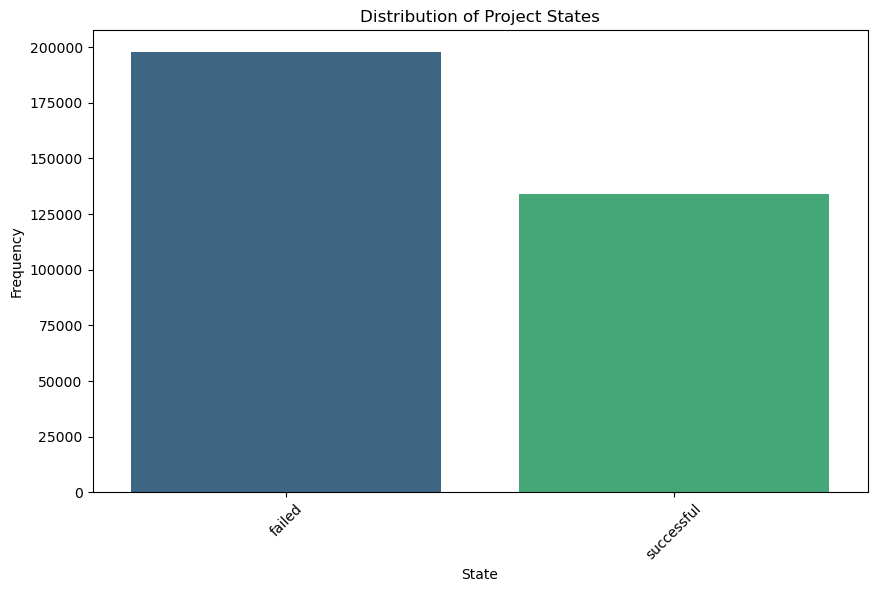

In [27]:
state_counts = startup_data['state'].value_counts()

plt.figure(figsize=(10, 6))
sb.barplot(x=state_counts.index, y=state_counts.values, palette='viridis')
plt.title('Distribution of Project States')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.show()

([<matplotlib.patches.Wedge at 0x1a7c3c63a00>,
 [Text(-0.32733952210997613, 1.0501660998455495, 'failed'),
  Text(0.3273395221099762, -1.0501660998455495, 'sucessful')],
 [Text(-0.17854883024180515, 0.572817872643027, '60%'),
  Text(0.17854883024180518, -0.572817872643027, '40%')])

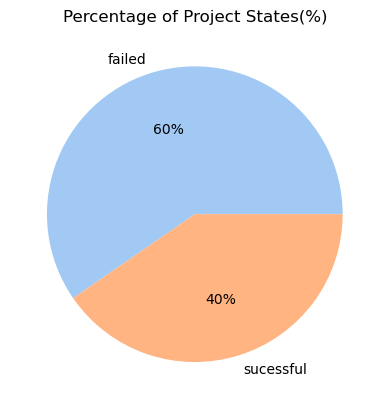

In [28]:
labels = ["failed","sucessful"]
data = state_counts
plt.title('Percentage of Project States(%)')
plt.pie(data, labels = labels, colors = sb.color_palette('pastel')[0:5], autopct='%.0f%%')

# Exploratory Data Analysis: Comparing Project State and Variables

Here, will select the variables to be analysed together with project state. We are aslo able to identify 2 main types of variables in a Kickstarter project.

Fixed Factors: Factors that are fixed determined from the beginning
1) Main Category of Project: main_category
2) Country Origin of Project: country
3) Kickstrater Goal Amount: usd_goal_real
4) Duration_of_campaign(days)

Variable Factors: Factors that will only be finalised at the end of the campaign
1) Amount of people that have contributed to the project: backers
2) Real Pledged Amount: usd_pledged_real

When we initially plotted a box plot for state vs numerical values, we realise there were a lot of outliers. So we removed the outliers for each factor.

We do this by finding absolute z-score which indicates the standard deviation of each data from the mean and then filtering data with more than z-score of 3 which are considered outliers.

We have considered creating a 'year' variable which would indicate the deadline year of a kickstarter project but there are many factors that can contribute to a lack of success over the years, and our dataset does not include such factors.

In [29]:
startup_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 0 to 378660
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   main_category               331462 non-null  object 
 1   state                       331462 non-null  object 
 2   backers                     331462 non-null  int64  
 3   country                     331462 non-null  object 
 4   usd_pledged_real            331462 non-null  float64
 5   usd_goal_real               331462 non-null  float64
 6   Duration_of_campaign(days)  331462 non-null  int64  
 7   Deadline(y)                 331462 non-null  int64  
 8   Launched(y)                 331462 non-null  int64  
 9   Launched(m)                 331462 non-null  int64  
 10  Deadline(m)                 331462 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 30.3+ MB


## Analysis of Variable 1: Goal Amount(Numerical)

In [14]:
#We cloned the data to focus on hypothesis 1, goal amount vs state
goal_amount = startup_data

In [15]:
#Removing Outliers
z_goal = np.abs(stats.zscore(goal_amount['usd_goal_real']))
threshold = 3
outliers_goal = goal_amount[z_goal > threshold]
goal_amount = goal_amount.drop(outliers_goal.index)

<Axes: xlabel='usd_goal_real', ylabel='state'>

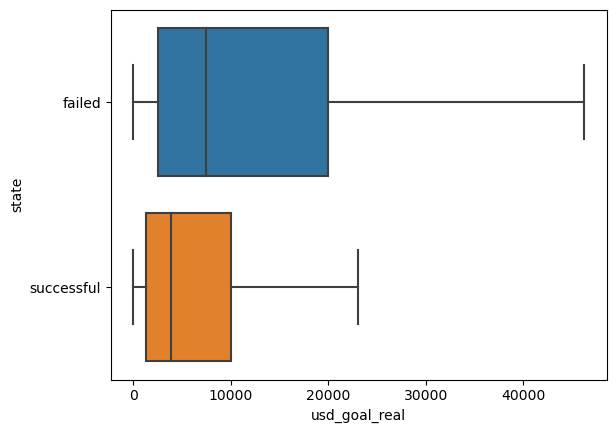

In [16]:
#In the following code, we plottted the box plot for goal amount vs state
sb.boxplot(data=goal_amount, x="usd_goal_real", y="state", showfliers = False)

In [17]:
print("Mean Goal Amounts:")
print(goal_amount.groupby('state')['usd_goal_real'].mean())

print("\nMedian Goal Amounts:")
print(goal_amount.groupby('state')['usd_goal_real'].median())


Mean Goal Amounts:
state
failed        30231.625639
successful     9535.701785
Name: usd_goal_real, dtype: float64

Median Goal Amounts:
state
failed        7500.0
successful    3840.0
Name: usd_goal_real, dtype: float64


Successful projects tend to have a significantly lower goal amounts on average compared to failed projects. The median values (less affected by outliers) highlights this point, showing that a typical successful project has a goal of about half or less than half of a failed project. <br>
Lets further examine the relationship

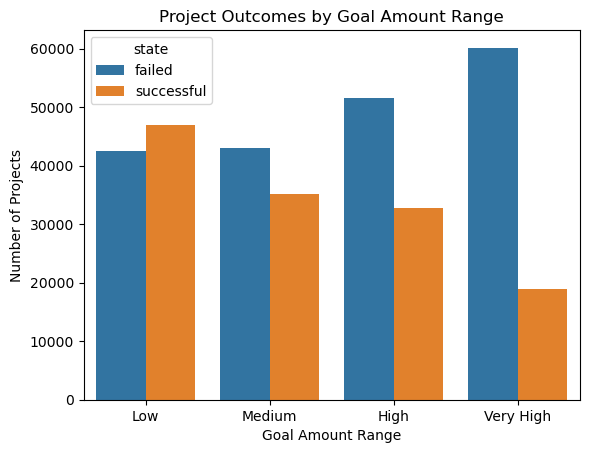

In [18]:
goal_amount['goal_range'] = pd.qcut(goal_amount['usd_goal_real'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

sb.countplot(data=goal_amount, x='goal_range', hue='state')
plt.xlabel('Goal Amount Range')
plt.ylabel('Number of Projects')
plt.title('Project Outcomes by Goal Amount Range')
plt.show()


There is a certain relationship where there is a higher number of failure when the goal amount is higher, and there is a higher amount of success when the goal amount is lower. <br>
Lets take a closer look at the success rate of the project by their goal amount range

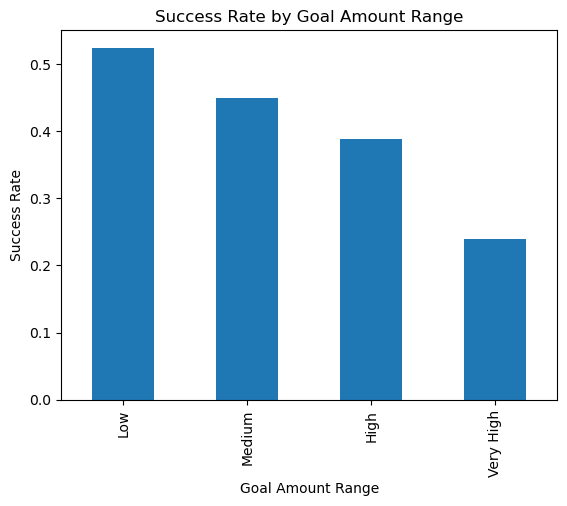

In [19]:
# Calculate success rate
success_rate = goal_amount.pivot_table(index='goal_range', columns='state', aggfunc='size', fill_value=0)
success_rate['success_rate'] = success_rate['successful'] / (success_rate['successful'] + success_rate['failed'])

# Plot
success_rate['success_rate'].plot(kind='bar')
plt.xlabel('Goal Amount Range')
plt.ylabel('Success Rate')
plt.title('Success Rate by Goal Amount Range')
plt.show()


From evidence, we could possibly conclude that the success of a kickstarter project could highly depend on the goal amonut, where if the goal is lower, the success rate tends to be higher.

## Analysis of Variable 2: Duration(Numerical)

In [20]:
#We cloned the data to focus on hypothesis 2, duration vs state
duration = startup_data

In [21]:
#Removing Outliers
z_duration = np.abs(stats.zscore(duration['Duration_of_campaign(days)']))
threshold = 3
outliers_duration = duration[z_duration > threshold]
duration = duration.drop(outliers_duration.index)

<Axes: xlabel='Duration_of_campaign(days)', ylabel='state'>

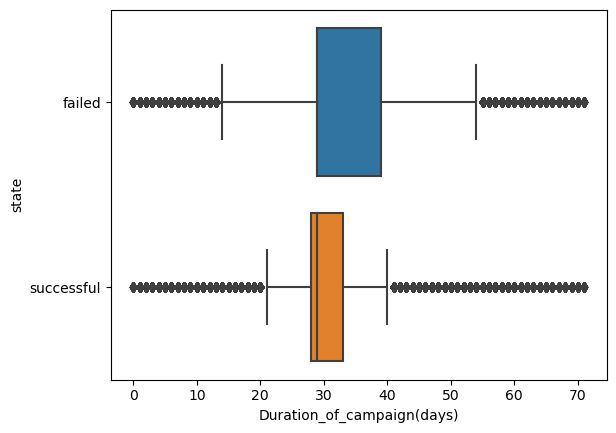

In [22]:
#In the following code, we plottted the box plot for duration vs state
sb.boxplot(data=duration, x="Duration_of_campaign(days)", y="state", showfliers = True)

In [23]:
print("Mean Duration of Campaign:")
print(duration.groupby('state')['Duration_of_campaign(days)'].mean())

print("\nMedian Duration of Campaign:")
print(duration.groupby('state')['Duration_of_campaign(days)'].median())

Mean Duration of Campaign:
state
failed        33.642687
successful    30.717827
Name: Duration_of_campaign(days), dtype: float64

Median Duration of Campaign:
state
failed        29.0
successful    29.0
Name: Duration_of_campaign(days), dtype: float64


Projects that failed has an average duration of about 34 days and projects that are successful have about 31 days. This suggests that projects that are within a months time are usually more successful. In fact, Kickstarter website states that there is a 60days limit to the campaigns, and they have found that projects lasting any longer than 60 days are rarely successful. They also recommend to set the duration to run for 30 days or less.<br><br>
we have to, however, keep in mind that there is a lot of outliers

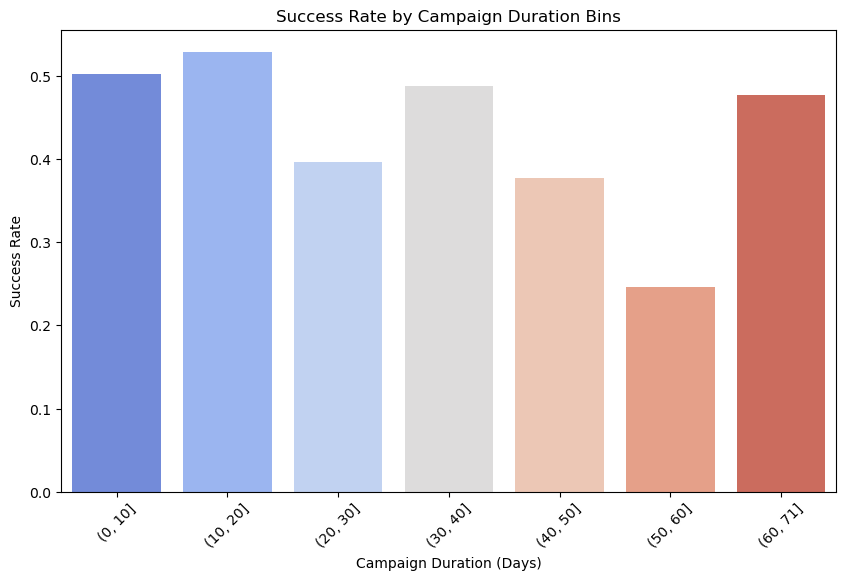

,Duration_Bins,Success_Rate
0,"(0, 10]",0.501984
1,"(10, 20]",0.528812
2,"(20, 30]",0.396296
3,"(30, 40]",0.487411
4,"(40, 50]",0.376625
5,"(50, 60]",0.245947
6,"(60, 71]",0.477419


In [24]:
# Binning the campaign duration into ranges for better analysis
duration['Duration_Bins'] = pd.cut(duration['Duration_of_campaign(days)'], bins=[0, 10, 20, 30, 40, 50, 60, duration['Duration_of_campaign(days)'].max()])

# Calculating success rates within each bin
success_rate_by_duration = duration.groupby('Duration_Bins').apply(lambda x: x[x['state'] == 'successful'].shape[0] / x.shape[0]).reset_index(name='Success_Rate')

# Plotting
plt.figure(figsize=(10, 6))
sb.barplot(data=success_rate_by_duration, x='Duration_Bins', y='Success_Rate', palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Success Rate by Campaign Duration Bins')
plt.xlabel('Campaign Duration (Days)')
plt.ylabel('Success Rate')
plt.show()

success_rate_by_duration


## Analysis of Variable 3: Backers(Numerical)

In [25]:
#We cloned the data to focus on varaible 3, backers vs state
backers = startup_data

In [26]:
#Removing Outliers
z_backers = np.abs(stats.zscore(backers['backers']))
threshold = 3
outliers_backers = backers[z_duration > threshold]
backers = backers.drop(outliers_duration.index)

<Axes: xlabel='backers', ylabel='state'>

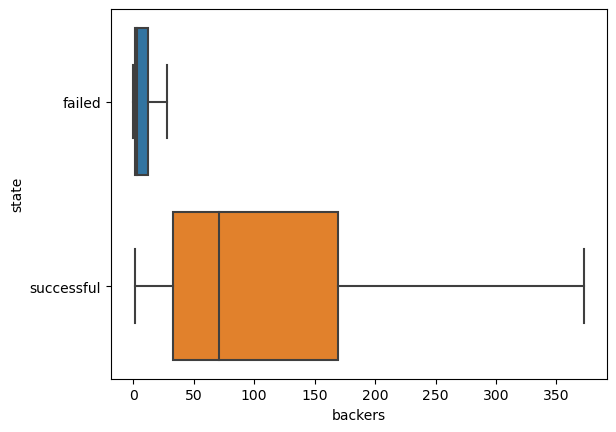

In [27]:
#In the following code, we plottted the box plot for backers vs state
sb.boxplot(data=backers, x="backers", y="state", showfliers = False)

In [28]:
print("Mean Number of Backers:")
print(backers.groupby('state')['backers'].mean())

print("\nMedian Number of Backers:")
print(backers.groupby('state')['backers'].median())


Mean Number of Backers:
state
failed         16.498137
successful    265.536782
Name: backers, dtype: float64

Median Number of Backers:
state
failed         3.0
successful    71.0
Name: backers, dtype: float64


The data is showing that the project would be more successful if there are more backers, which makes sense, now lets look at the success to see the correlation

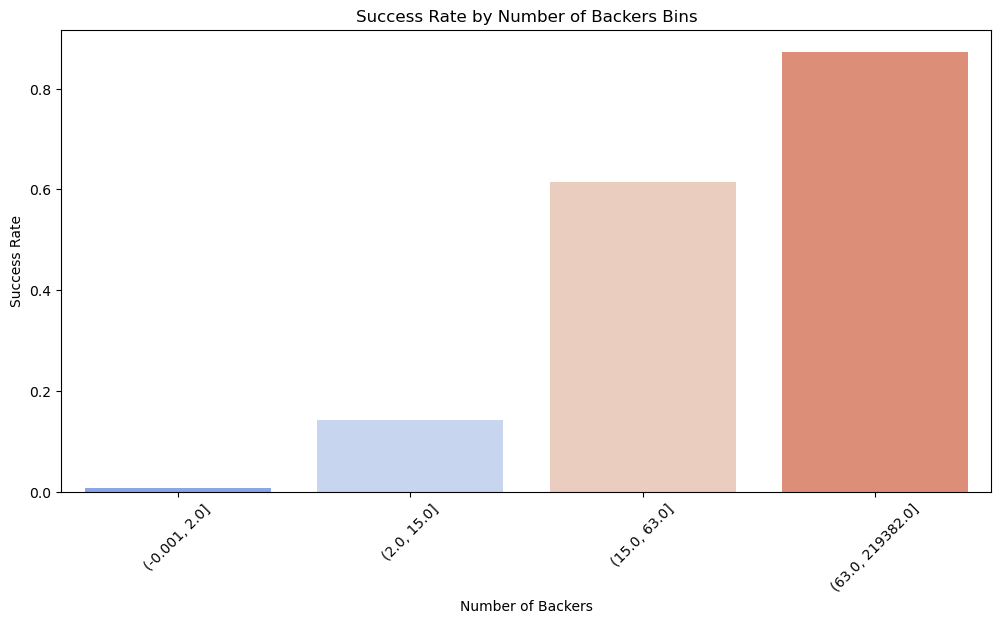

In [29]:
# Binning the number of backers into ranges for easier analysis
backers['Backers_Bins'] = pd.qcut(backers['backers'], q=4, duplicates='drop')  

# Calculating success rates within each bin
success_rate_by_backers = backers.groupby('Backers_Bins')['state'].apply(lambda x: (x == 'successful').mean()).reset_index(name='Success_Rate')

# Plotting
plt.figure(figsize=(12, 6))
sb.barplot(data=success_rate_by_backers, x='Backers_Bins', y='Success_Rate', palette='coolwarm')
plt.title('Success Rate by Number of Backers Bins')
plt.xlabel('Number of Backers')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.show()


## Analysis of Variable 4: Pledged Amount(Numerical)

In [30]:
#We cloned the data to focus on variable 4, pledge amount vs state
pledge = startup_data

In [31]:
z_pledge = np.abs(stats.zscore(backers['usd_pledged_real']))
threshold = 3
outliers_pledge = backers[z_pledge > threshold]
pledge = pledge.drop(outliers_duration.index)

<Axes: xlabel='usd_pledged_real', ylabel='state'>

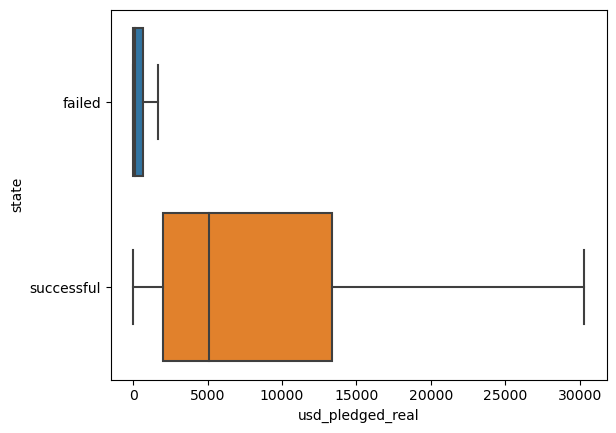

In [32]:
#In the following code, we plottted the box plot for backers vs state
sb.boxplot(data=pledge, x="usd_pledged_real", y="state", showfliers = False)

In [33]:
print("Mean Number of Backers:")
print(pledge.groupby('state')['usd_pledged_real'].mean())

print("\nMedian Number of Backers:")
print(pledge.groupby('state')['usd_pledged_real'].median())


Mean Number of Backers:
state
failed         1327.323792
successful    22784.109481
Name: usd_pledged_real, dtype: float64

Median Number of Backers:
state
failed         100.0
successful    5115.0
Name: usd_pledged_real, dtype: float64


Data over here is also showing that if there is a higher amount pledge, the project tend to be more successful. 

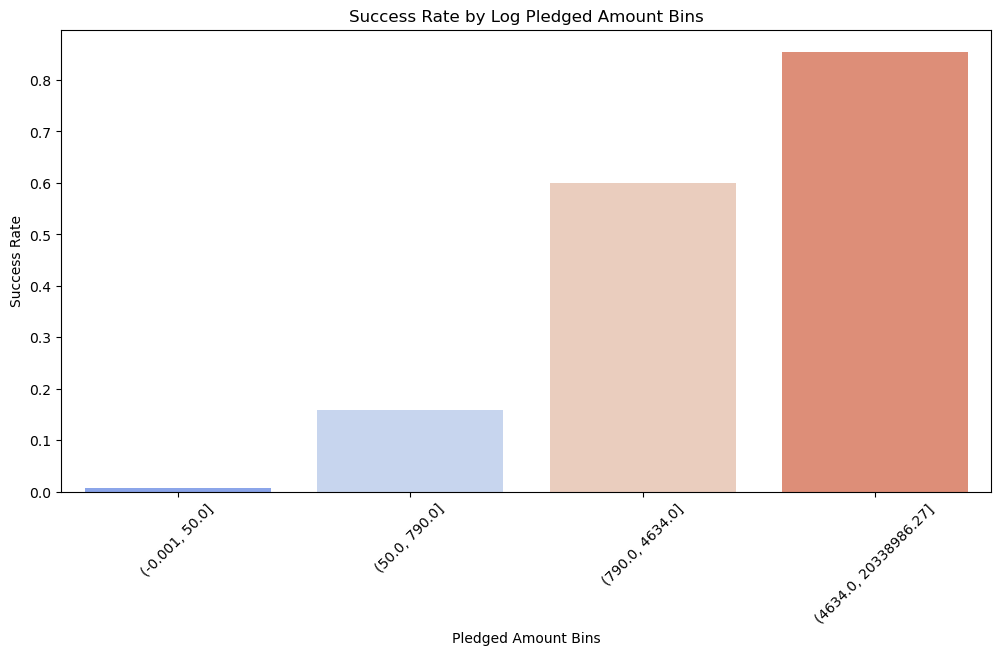

In [34]:
pledge['Pledged_Bins'] = pd.qcut(pledge['usd_pledged_real'], q=4, duplicates='drop')

success_rate_by_pledged = pledge.groupby('Pledged_Bins')['state'].apply(lambda x: (x == 'successful').mean()).reset_index(name='Success_Rate')

plt.figure(figsize=(12, 6))
sb.barplot(data=success_rate_by_pledged, x='Pledged_Bins', y='Success_Rate', palette='coolwarm')
plt.title('Success Rate by Log Pledged Amount Bins')
plt.xlabel('Pledged Amount Bins')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.show()


## Analysis of Variable 5: main_categories(Categorical)

In [35]:
#We cloned the data to focus on variable 5, category vs state
category = startup_data

C:\Users\mythi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


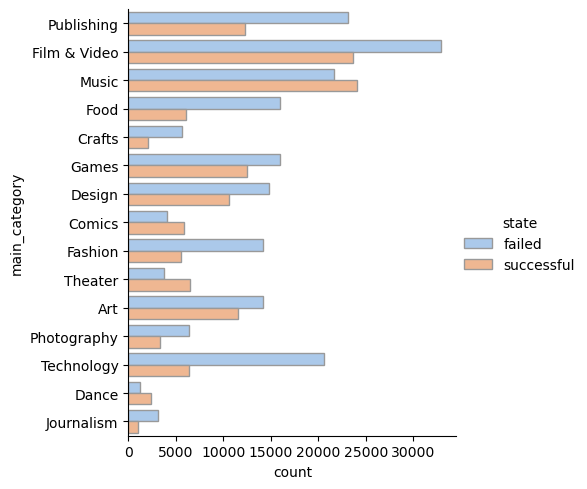

In [36]:
sb.catplot(data=category, y="main_category", hue="state", kind="count",palette="pastel", edgecolor=".6",)

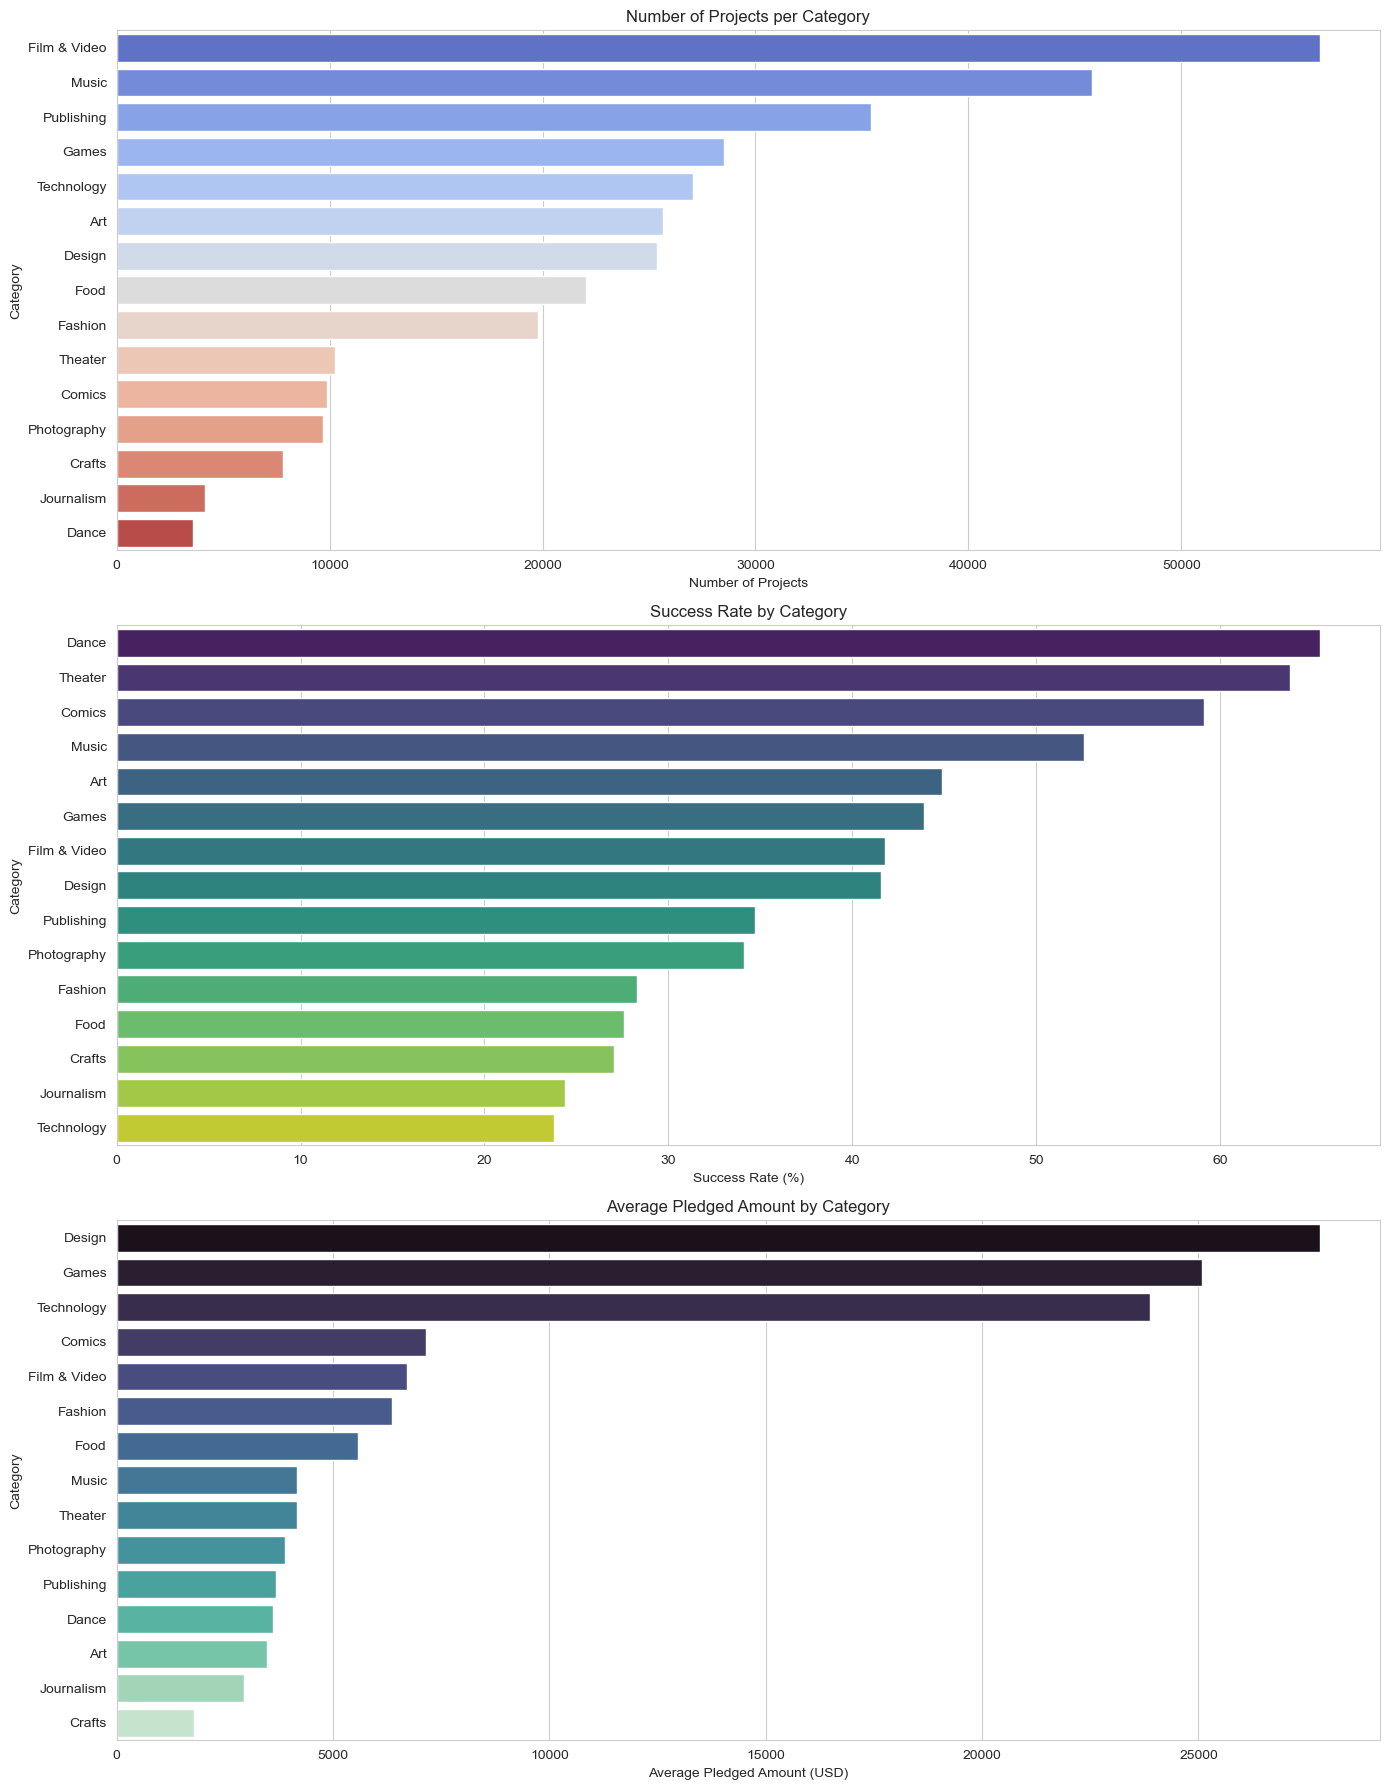

In [37]:
# Set the aesthetic style of the plots
sb.set_style("whitegrid")

# 1. Distribution of projects across different categories
category_counts = category['main_category'].value_counts()

# 2. Success rate (number of successful projects vs total projects) per category
success_counts = category[category['state'] == 'successful']['main_category'].value_counts()
total_counts = category['main_category'].value_counts()
success_rate = (success_counts / total_counts * 100).sort_values(ascending=False)

# 3. Average pledged amount by category
average_pledged = category.groupby('main_category')['usd_pledged_real'].mean().sort_values(ascending=False)

# Plotting all the figures
plt.figure(figsize=(14, 18))

plt.subplot(3, 1, 1)
sb.barplot(y=category_counts.index, x=category_counts.values, palette='coolwarm')
plt.title('Number of Projects per Category')
plt.xlabel('Number of Projects')
plt.ylabel('Category')

plt.subplot(3, 1, 2)
sb.barplot(y=success_rate.index, x=success_rate.values, palette='viridis')
plt.title('Success Rate by Category')
plt.xlabel('Success Rate (%)')
plt.ylabel('Category')

plt.subplot(3, 1, 3)
sb.barplot(y=average_pledged.index, x=average_pledged.values, palette='mako')
plt.title('Average Pledged Amount by Category')
plt.xlabel('Average Pledged Amount (USD)')
plt.ylabel('Category')

plt.tight_layout()
plt.show()


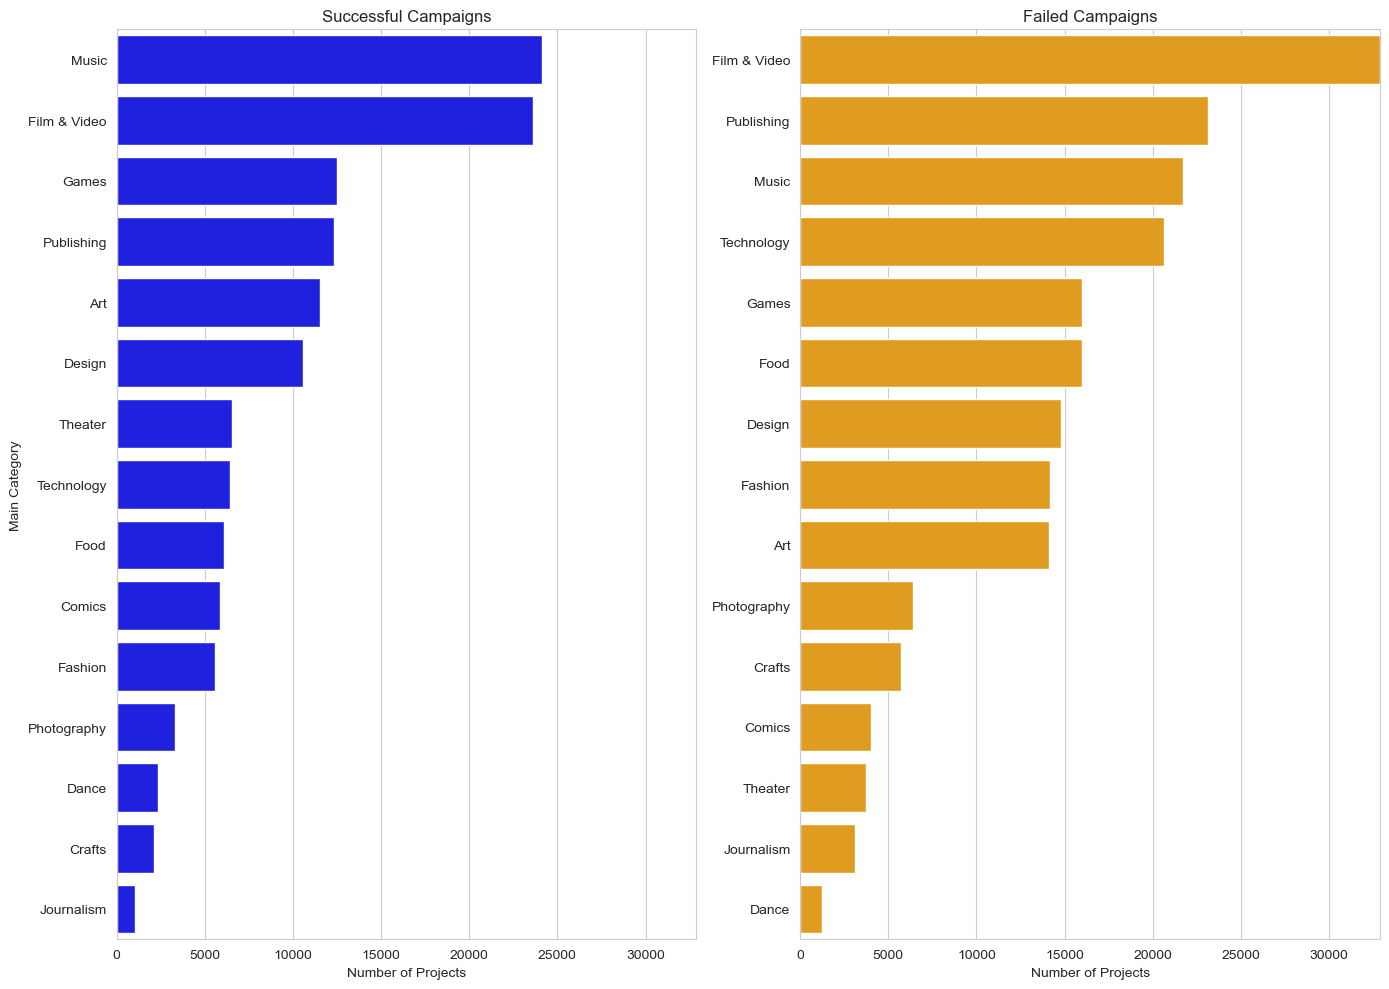

In [38]:
success_failures = category.groupby(['main_category', 'state']).size().unstack(fill_value=0)
success_failures['successful'] = success_failures['successful'].fillna(0)
success_failures['failed'] = success_failures['failed'].fillna(0)

# Sort the categories by the number of successful projects in descending order
sorted_categories_success = success_failures['successful'].sort_values(ascending=False).index
sorted_categories_failure = success_failures['failed'].sort_values(ascending=False).index

# Sorting the dataframe according to the sorted categories
success_sorted = success_failures.loc[sorted_categories_success]
failures_sorted = success_failures.loc[sorted_categories_failure]


plt.figure(figsize=(14, 10))

# Plot for successful campaigns
plt.subplot(1, 2, 1)
sb.barplot(x=success_failures.loc[sorted_categories_success]['successful'], y=success_sorted.index, color='blue', orient='h')
plt.title('Successful Campaigns')
plt.xlabel('Number of Projects')
plt.ylabel('Main Category')

# Plot for failed campaigns
plt.subplot(1, 2, 2)
sb.barplot(x=success_failures.loc[sorted_categories_failure]['failed'], y=failures_sorted.index, color='orange', orient='h')
plt.title('Failed Campaigns')
plt.xlabel('Number of Projects')
plt.ylabel('')

# Set the x-limits to be equal for comparison
max_limit = max(success_sorted['successful'].max(), failures_sorted['failed'].max())
plt.subplot(1, 2, 1).set_xlim(0, max_limit)
plt.subplot(1, 2, 2).set_xlim(0, max_limit)

# Improve layout to avoid overlapping
plt.tight_layout()
plt.show()


# Analysis of Variable 6: Countries(Categorical)

In [39]:
#We cloned the data to focus on variable 6, country vs state
country = startup_data

C:\Users\mythi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


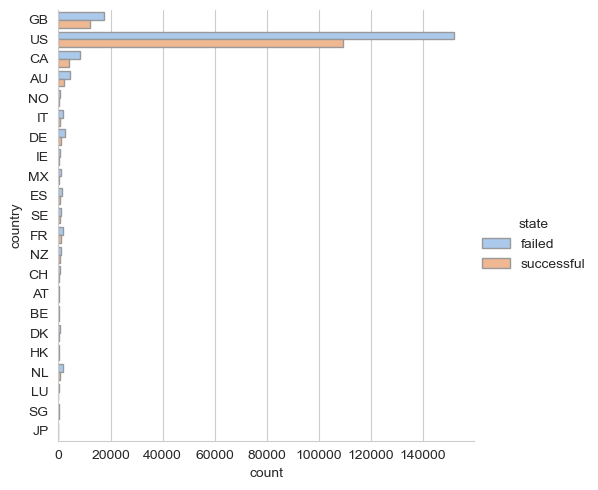

In [40]:
sb.catplot(data=country, y="country", hue="state", kind="count",palette="pastel", edgecolor=".6",)

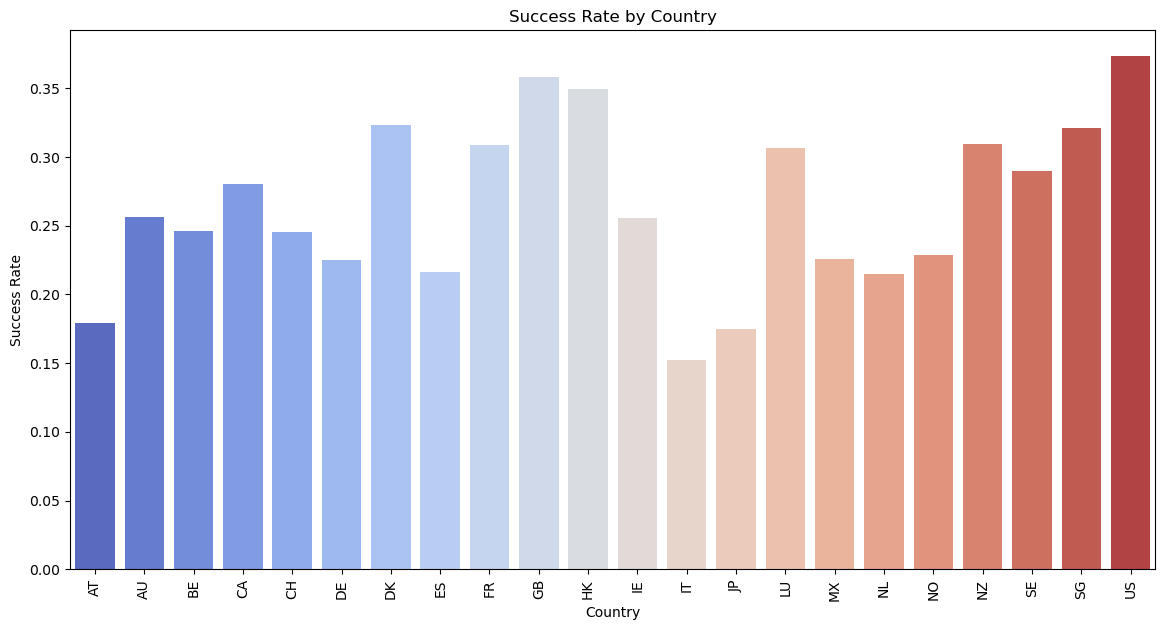

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

cleaned_data = startup_data[startup_data['country'] != 'N,0"']
country_state_counts = cleaned_data.groupby(['country', 'state']).size().unstack(fill_value=0)
country_state_counts['Total'] = country_state_counts.sum(axis=1)
country_state_counts['Success Rate'] = country_state_counts['successful'] / country_state_counts['Total']

# Reset index to turn multi-index into columns
country_state_counts.reset_index(inplace=True)

# Plotting
plt.figure(figsize=(14, 7))  # Adjust size as needed
sb.barplot(x='country', y='Success Rate', data=country_state_counts, palette='coolwarm')
plt.xticks(rotation=90)  # Rotate country names for better visibility
plt.title('Success Rate by Country')
plt.xlabel('Country')
plt.ylabel('Success Rate')
plt.show()

We were able to form some insights from our initial exploratory analysis.
1) Successful kickstarters tend to have lower goal amounts
2) The 'sweet spot' duration for successful kickstarter is between 20 to 40 days
3) Successful kickstarters have more backers
4) Successful kickstarters were able to raise more money
5) Certain categories are more likely to be sucessful, like Theatre and Music
6) Most projects are based in GB, US, CA, AU, IT and DE and most countries seem to have similar rates of success for their projects

# Machine Learning <a name="ml"></a>
In this part, we will be creating models using data to predict success and failure of a kickstarter project.

## Variable Selection for Models
Variables we want to use in the models are fixed factors which that are determined from the beginning. This is because we want to predict whether a project will fail or suceed while it is still campaigning. Once it's over, there's no point predicting it since we can check it directly from the site (e.g. usd_goal_real).

These are the variables we will be using to create a model
1) main_category
2) usd_goal_real
3) country
4) Duration_of_campaign(days)
5) backers
6) state

We have dropped usd_pledged_real because success is defined by success = usd_pledged real >= usd_goal_real. Because of this, we have to drop the column to avoid overfitting and prevent the model from overly relying on this feature, which could lead to overgeneralizing. 

In [41]:
model_data = startup_data[['main_category','country','Duration_of_campaign(days)','usd_goal_real', 'state', 'backers']]

## Encoding catergorical data <a name="encoding"></a>
We will encode these categorical data: "main_category" and "country" using OneHotEncoder to ensure that there is no order for these categories.

In [42]:
ohe = OneHotEncoder()
model_data_cat = model_data[['main_category','country']]
ohe.fit(model_data_cat)
model_data_cat_ohe = pd.DataFrame(ohe.transform(model_data_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(model_data_cat.columns))

model_data_cat_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331462 entries, 0 to 331461
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   main_category_Art           331462 non-null  float64
 1   main_category_Comics        331462 non-null  float64
 2   main_category_Crafts        331462 non-null  float64
 3   main_category_Dance         331462 non-null  float64
 4   main_category_Design        331462 non-null  float64
 5   main_category_Fashion       331462 non-null  float64
 6   main_category_Film & Video  331462 non-null  float64
 7   main_category_Food          331462 non-null  float64
 8   main_category_Games         331462 non-null  float64
 9   main_category_Journalism    331462 non-null  float64
 10  main_category_Music         331462 non-null  float64
 11  main_category_Photography   331462 non-null  float64
 12  main_category_Publishing    331462 non-null  float64
 13  main_category_

In [43]:
# Combining Numeric features with the OHE Categorical features
model_num = model_data[['Duration_of_campaign(days)','usd_goal_real','backers']]
model_res = startup_data['state']
model_data_ohe = pd.concat([model_num, model_data_cat_ohe, model_res], 
                           sort = False, axis = 1).reindex(index=model_num.index)

# Resetting indexes to ensure alignment
model_num_reset = model_num.reset_index(drop=True)
model_data_cat_ohe_reset = model_data_cat_ohe.reset_index(drop=True)
model_res_reset = model_res.reset_index(drop=True)

# Concatenating the DataFrames with reset indexes
model_data_ohe = pd.concat([model_num_reset, model_data_cat_ohe_reset, model_res_reset], axis=1)

# Check the final dataframe
model_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331462 entries, 0 to 331461
Data columns (total 41 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Duration_of_campaign(days)  331462 non-null  int64  
 1   usd_goal_real               331462 non-null  float64
 2   backers                     331462 non-null  int64  
 3   main_category_Art           331462 non-null  float64
 4   main_category_Comics        331462 non-null  float64
 5   main_category_Crafts        331462 non-null  float64
 6   main_category_Dance         331462 non-null  float64
 7   main_category_Design        331462 non-null  float64
 8   main_category_Fashion       331462 non-null  float64
 9   main_category_Film & Video  331462 non-null  float64
 10  main_category_Food          331462 non-null  float64
 11  main_category_Games         331462 non-null  float64
 12  main_category_Journalism    331462 non-null  float64
 13  main_category_

## Upsampling
There are more failures than sucesses which will result in a skewed and inaccurate result. Thus, we will utilise upsampling to balance the number of datas for successful and failed projects to create a more accurate model.

In [44]:
# Upsample good to match bad
from sklearn.utils import resample

failed = model_data_ohe[model_data_ohe.state == 'failed']
successful = model_data_ohe[model_data_ohe.state == 'successful']
 
# Upsample the Bad samples
successful_up = resample(successful, 
                        replace=True,                     # sample with replacement
                        n_samples=failed.shape[0])    # to match number of Good
 
# Combine the two classes back after upsampling
model_data_ohe_up = pd.concat([successful_up,failed])
 
# Check the ratio of the classes
model_data_ohe_up['state'].value_counts()

state
successful    197611
failed        197611
Name: count, dtype: int64

## Model 1: Decision Tree <a name="decision_tree"></a>
We will be creating a model using decision tree with encoded and upsampled data. After encoding and upsampling, we created and fit the `DecisionTreeClassifier` model on the dataset.

[Text(0.5, 0.9, 'backers <= 14.5\ngini = 0.5\nsamples = 276655\nvalue = [138481, 138174]\nclass = successful'),
 Text(0.25, 0.7, 'usd_goal_real <= 758.915\ngini = 0.171\nsamples = 118910\nvalue = [107681, 11229]\nclass = successful'),
 Text(0.125, 0.5, 'backers <= 4.5\ngini = 0.488\nsamples = 19379\nvalue = [11173, 8206]\nclass = successful'),
 Text(0.0625, 0.3, 'usd_goal_real <= 130.065\ngini = 0.236\nsamples = 10816\nvalue = [9336, 1480]\nclass = successful'),
 Text(0.03125, 0.1, 'gini = 0.474\nsamples = 2587\nvalue = [1591, 996]\nclass = successful'),
 Text(0.09375, 0.1, 'gini = 0.111\nsamples = 8229\nvalue = [7745, 484]\nclass = successful'),
 Text(0.1875, 0.3, 'backers <= 8.5\ngini = 0.337\nsamples = 8563\nvalue = [1837, 6726]\nclass = failed'),
 Text(0.15625, 0.1, 'gini = 0.461\nsamples = 3674\nvalue = [1326, 2348]\nclass = failed'),
 Text(0.21875, 0.1, 'gini = 0.187\nsamples = 4889\nvalue = [511, 4378]\nclass = failed'),
 Text(0.375, 0.5, 'backers <= 9.5\ngini = 0.059\nsamples =

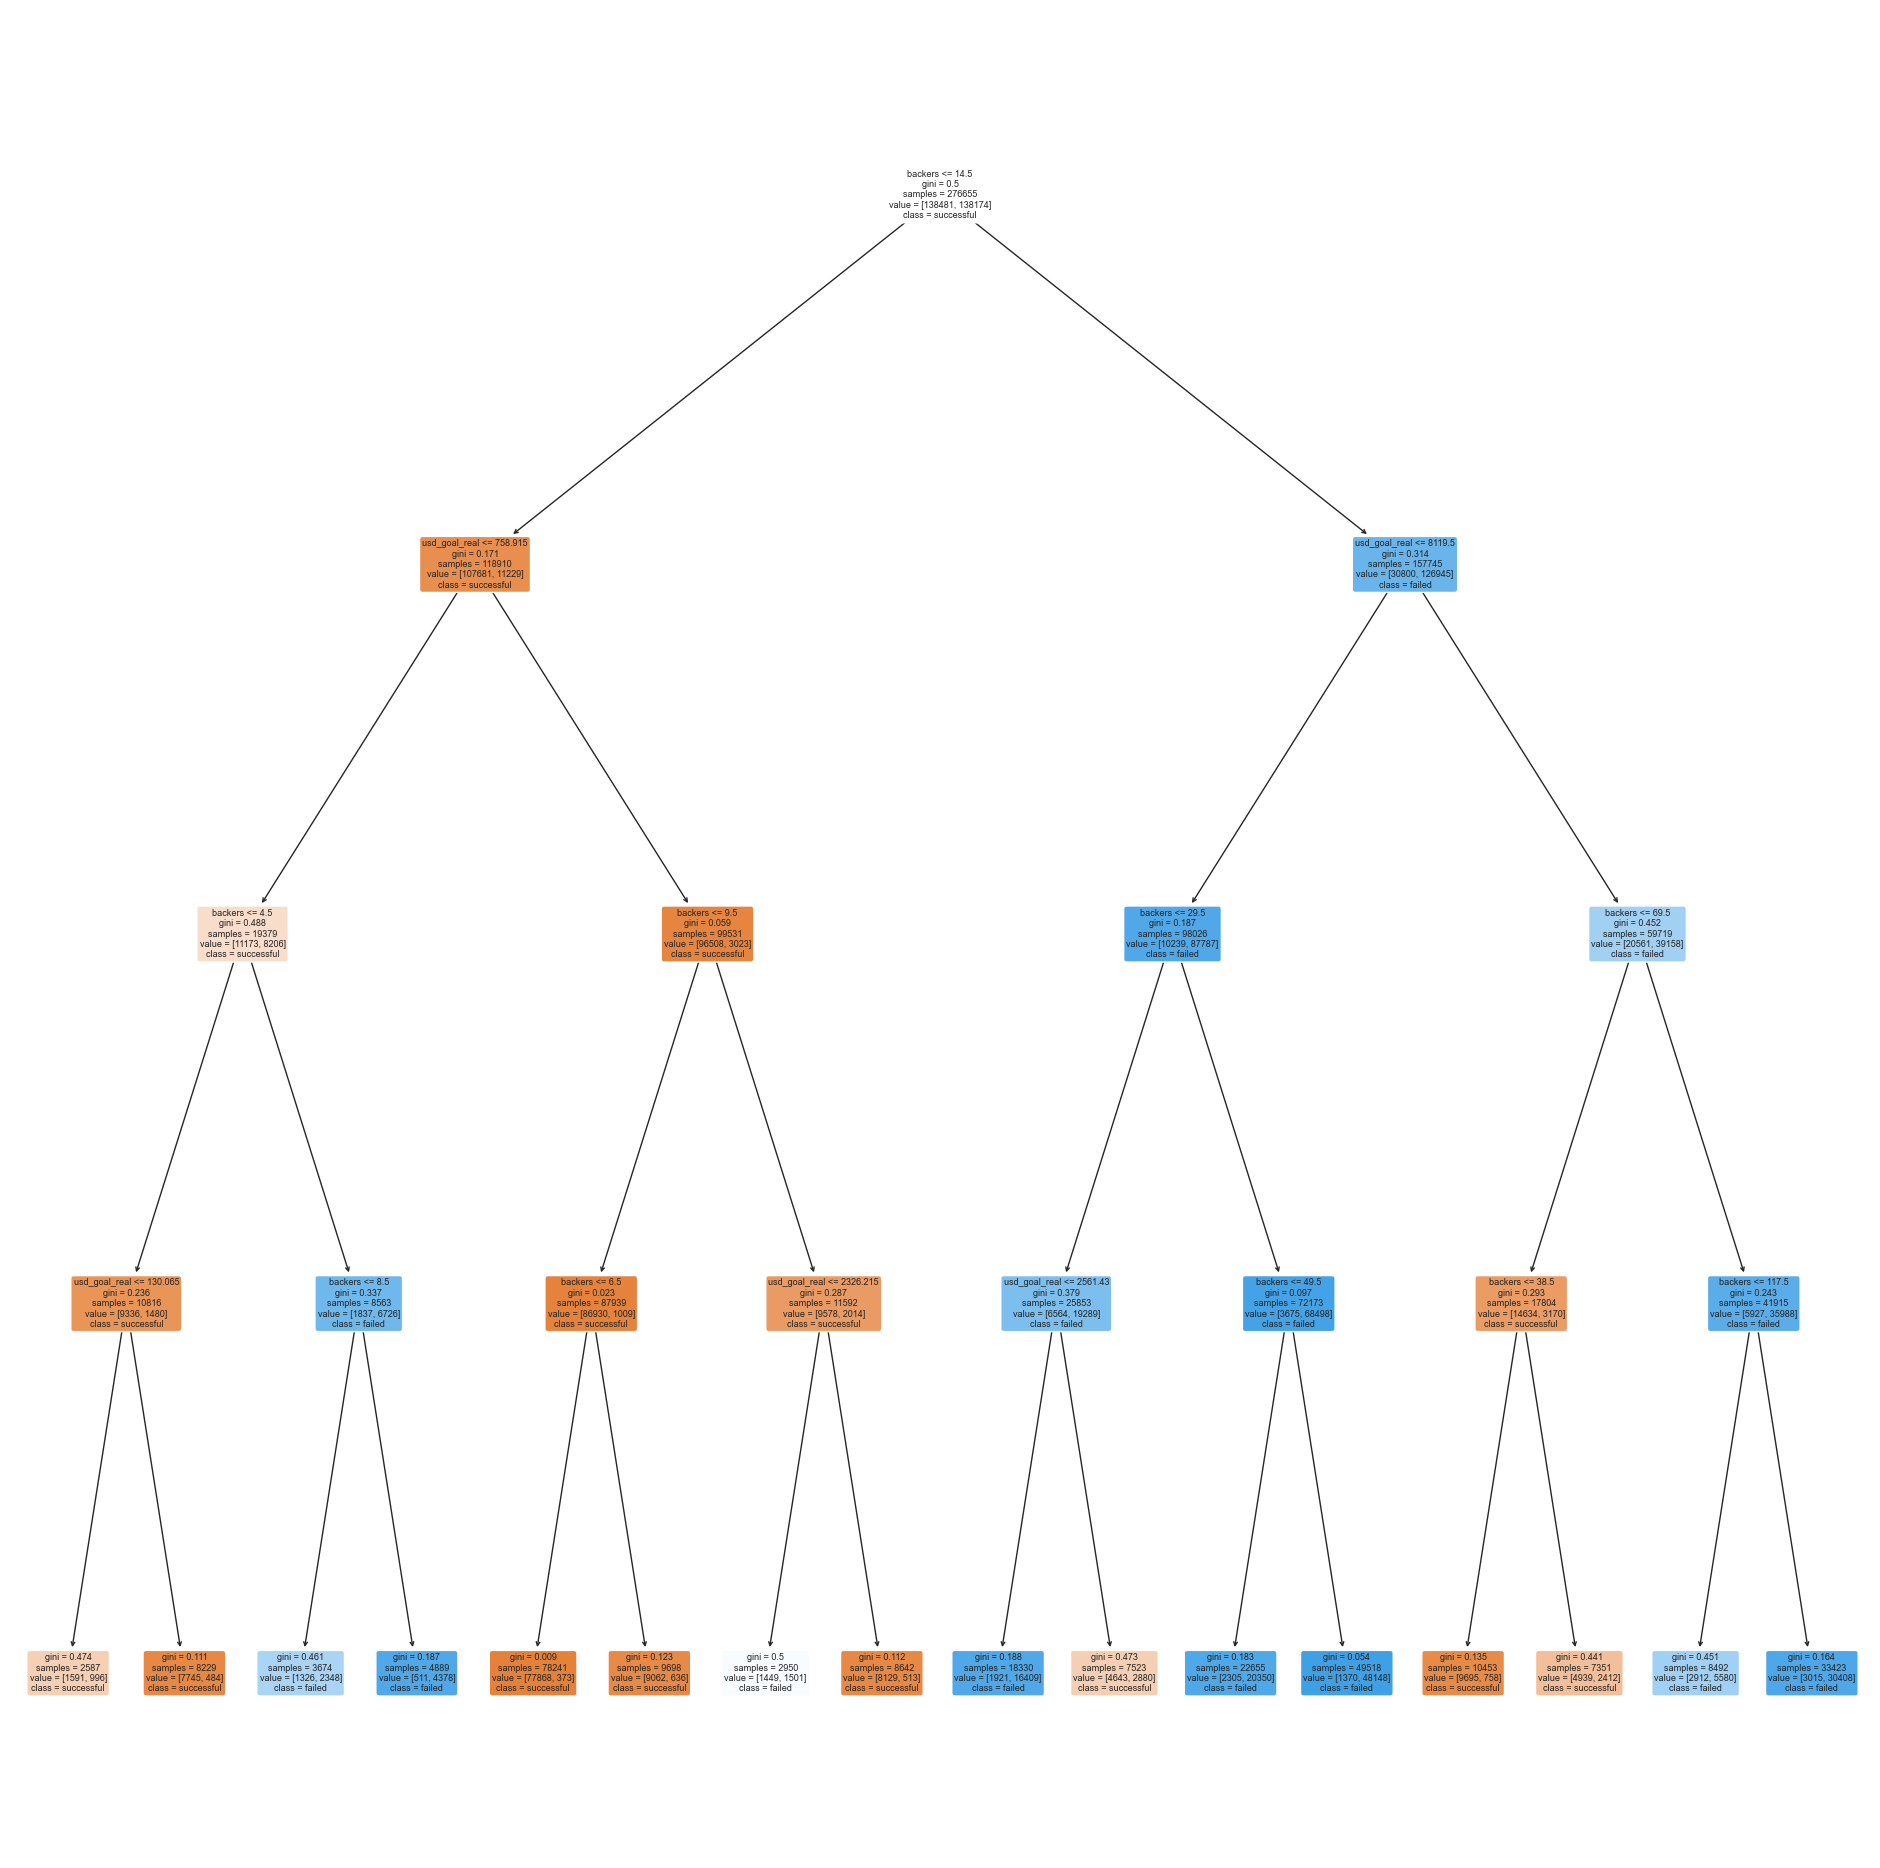

In [45]:
# Extract Response and Predictors
y = pd.DataFrame(model_data_ohe_up['state'])
X = pd.DataFrame(model_data_ohe_up.drop('state', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=list(X_train.columns), 
          class_names=["successful", "failed"]) #added list() to make it work

### Checking Accuracy of the Decision Tree Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

Train Data
Accuracy  :	 0.9137517847138132

TPR Train :	 0.9344883986857151
TNR Train :	 0.8930611419617132

FPR Train :	 0.10693885803828684
FNR Train :	 0.06551160131428489


<Axes: >

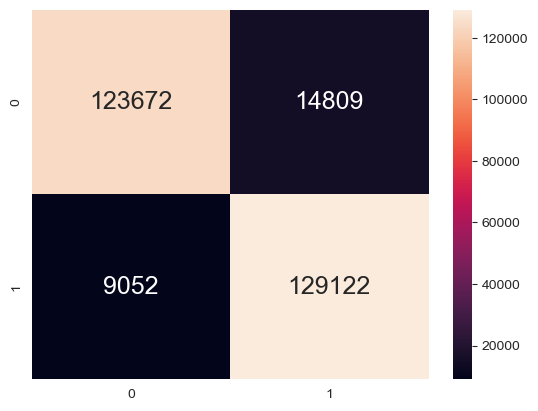

In [46]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.913660630698255

TPR Test :	 0.933559903763649
TNR Test :	 0.8936580416032471

FPR Test :	 0.10634195839675292
FNR Test :	 0.0664400962363511


<Axes: >

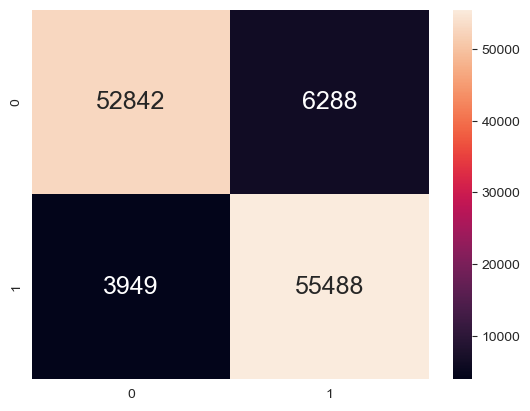

In [47]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Conclusion for Decision Tree
The decision tree model is able the success and failure of a project quite accurately with a accuracy of 0.913 on Test Data.

## Model 2: Random Forest <a name="random_forest"></a>
Next, we will be creating a model using random forest with encoded and upsampled data to find out if we can create a better model than decision tree. We will keep the upsampled and encoded data from our previous attempt.

In [48]:
# Extract Response and Predictors
y = pd.DataFrame(model_data_ohe_up['state'])
X = pd.DataFrame(model_data_ohe_up.drop('state', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [49]:
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees # CHANGE AND EXPERIMENT
                                 max_depth = 4)       # set the maximum depth of each tree # CHANGE AND EXPERIMENT

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.state.ravel())

RandomForestClassifier(max_depth=4)

Train Data
Accuracy  :	 0.8616399486725344

TPR Train :	 0.9195423043603812
TNR Train :	 0.8035762116769827

FPR Train :	 0.19642378832301735
FNR Train :	 0.08045769563961883


<Axes: >

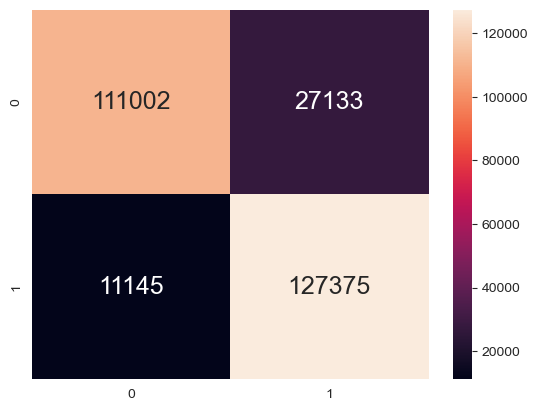

In [50]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8611755378815353

TPR Test :	 0.9200385845560237
TNR Test :	 0.8026935234380255

FPR Test :	 0.1973064765619746
FNR Test :	 0.07996141544397624


<Axes: >

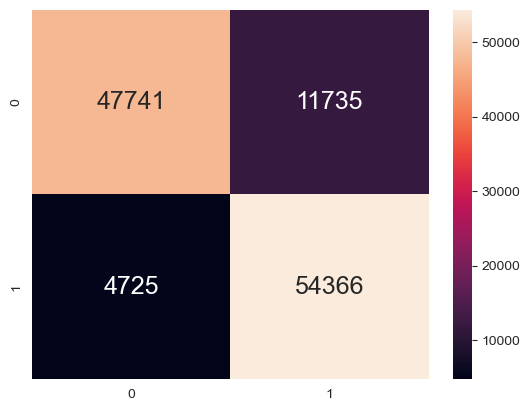

In [51]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Conclusion for Random Forest
The random forest model is able the success and failure of a project with an accuracy of 0.8611 on Test Data which is lower than the accuracy of decsion tree.

## Model 3: Random Forest with Cross-Validation
We tried tuning the Hyper-parameters of Random Forest to make it more accurate by using GridSearchCV.

In [61]:
# Extract Response and Predictors
y = pd.DataFrame(model_data_ohe_up['state'])
X = pd.DataFrame(model_data_ohe_up.drop('state', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [62]:
# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,301,100),   # number of trees 100,200..... 300
              'max_depth': np.arange(2,3)}             # depth of trees 2, 3, 4, 5....

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.state.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([2]),
                         'n_estimators': array([100, 200, 300])},
             scoring='accuracy')

In [63]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=2)
0.8605158048833385


Cross-Validation routine selects the `best_estimator_` based on the `scoring` parameter of `accuracy`. We used scoring system, `accuracy`to find the random forest model with the best accuracy.

### Using the Best Random Forest Model found through GridSearchCV

In [64]:
# Extract Response and Predictors
y = pd.DataFrame(model_data_ohe_up['state'])
X = pd.DataFrame(model_data_ohe_up.drop('state', axis = 1))
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 200,   # replace with best estimator found using GridSearchCV
                                 max_depth = 2)       # replace with best max depth found using GridSearchCV

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.state.ravel())

RandomForestClassifier(max_depth=2, n_estimators=200)

Train Data
Accuracy  :	 0.8658112089063996

TPR Train :	 0.921764680402547
TNR Train :	 0.8097034103824464

FPR Train :	 0.19029658961755358
FNR Train :	 0.07823531959745304


<Axes: >

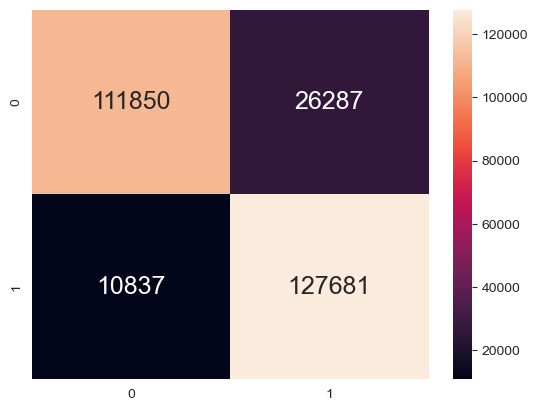

In [65]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8645407238101664

TPR Test :	 0.9222750579594876
TNR Test :	 0.8071762450818846

FPR Test :	 0.1928237549181155
FNR Test :	 0.07772494204051242


<Axes: >

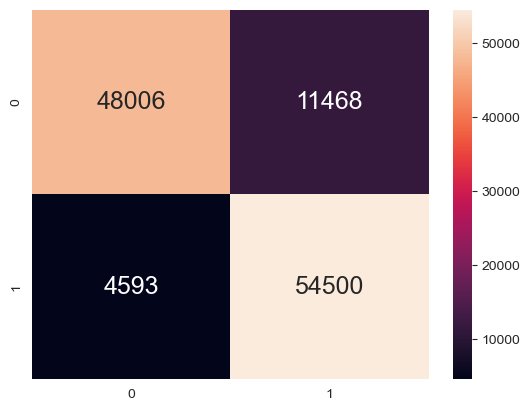

In [66]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Conclusion for Random Forest with Cross-Validation

## Model 4: XGB Classifier <a name="xgb"></a>

In [58]:
y = pd.DataFrame(model_data_ohe_up['state'])
X = pd.DataFrame(model_data_ohe_up.drop('state', axis = 1))
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Transform both training and testing target variables
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Fit the model on the training data
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train_encoded)

# Predict on the test data
y_pred_xgb = xgbc.predict(X_test)

# Since the predictions are in encoded form, use the encoded y_test for evaluation
print("Confusion Matrix: \n", confusion_matrix(y_test_encoded, y_pred_xgb))
print("Accuracy Score for Test Set: ", accuracy_score(y_test_encoded, y_pred_xgb))

# Optionally, you might want to check accuracy on the training set
y_pred_train_xgb = xgbc.predict(X_train)
print("Accuracy Score for Training Set: ", accuracy_score(y_train_encoded, y_pred_train_xgb))

C:\Users\mythi\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mythi\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Confusion Matrix: 
 [[54749  4592]
 [ 3249 55977]]
Accuracy Score for Test Set:  0.9338686143699343
Accuracy Score for Training Set:  0.9389420035784641


### Conclusion for XGB Classifier

## Model 5: XGB Classifier with Cross-Validation
-

### Using the Best XGB Classifier Model found through GridSearchCV

In [59]:


params = {
    'max_depth': [4, 5],
    'min_child_weight': [5, 10],
    'subsample': [0.8, 1.0],
    'learning_rate': [0.01, 0.1]
}

xgb = XGBClassifier(verbosity=1)
grid_search = GridSearchCV(xgb, param_grid=params, scoring='accuracy', n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train_encoded)



GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 5],
                         'min_child_weight': [5, 10], 'subsample': [0.8, 1.0]},
             scoring='accuracy')

In [60]:
# Predict on the test data
y_pred_xgb = grid_search.predict(X_test)


# Since the predictions are in encoded form, use the encoded y_test for evaluation
print("Confusion Matrix: \n", confusion_matrix(y_test_encoded, y_pred_xgb))
print("Accuracy Score for Test Set: ", accuracy_score(y_test_encoded, y_pred_xgb))

Confusion Matrix: 
 [[54525  4816]
 [ 3200 56026]]
Accuracy Score for Test Set:  0.9323926556293066
